In [1]:
import transcriptic 
from transcriptic import commands, Container
from transcriptic.config import Connection
from transcriptic.jupyter import objects
import json
from pysd2cat.data import tx_fcs
from pysd2cat.data import pipeline
#from pysd2cat.analysis import biofab_live_dead_analysis as blda
#from pysd2cat.data import biofab_live_dead as bld


from os.path import expanduser
import requests
import os
import zipfile
import shutil
import fnmatch
import glob
import pandas as pd
import ast

import pysd2cat.analysis.container_data_conversion as cdc
from pysd2cat.analysis.plate_layout import solve1, get_model_pd, get_sample_types


%load_ext autoreload
%reload_ext autoreload
%autoreload 2

Connection.from_file("~/.transcriptic")

/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/FlowCytometryTools/core/docstring.py:56: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  doc = dedent(doc)
/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/FlowCytometryTools/core/docstring.py:56: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  doc = dedent(doc)


In [2]:
def convert_ftypes(factors):
    for factor_id, factor in factors.items():
        if factor_id == "strain" or factor_id == "replicate":
            factor['ftype'] = 'aliquot'
        elif factor_id == "timepoint":
            factor['ftype'] = 'sample'
        
    return factors

def strip_aliquot_properties(container):
    for aliquot_id in container['aliquots']:
        container['aliquots'][aliquot_id] = {}
    return container

In [25]:
ex_num = 0
experiment_files = [
    "gen_experiment_request_growth_curve.json",
    "gen_experiment_request_growth_curve_corrected.json", # Need to fix container ids
    ""
]
this_dir = os.getcwd()
experiment_file_dir = os.path.realpath(os.path.join(this_dir, '../../../tests/data/'))

request = json.load(open(os.path.join(experiment_file_dir, experiment_files[ex_num])))

c2ds  = { container.id : strip_aliquot_properties(cdc.container_to_dict(container))
          for container in [objects.Container(x) for x in request['defaults']['constants']['container_search_string']]  }

inputs = {
    "samples" : None,
    "factors" : convert_ftypes(request['condition_space']['factors']),
    "requirements" : request['defaults']['conditions'],
    "containers" : c2ds
}

import logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
logging.debug("test")

model, variables = solve1(inputs)
df = get_model_pd(model, variables, inputs['factors'])


DEBUG:urllib3.connectionpool:https://secure.transcriptic.com:443 "GET /-/ct1dqvp6p255zar HTTP/1.1" 302 None
DEBUG:urllib3.connectionpool:https://secure.transcriptic.com:443 "GET /sd2org/inventory/samples/ct1dqvp6p255zar?action=deref&controller=user_base&gid=ct1dqvp6p255zar HTTP/1.1" 200 None
DEBUG:urllib3.connectionpool:https://secure.transcriptic.com:443 "GET /-/ct1dqvp6ntpb7e3 HTTP/1.1" 302 None
DEBUG:urllib3.connectionpool:https://secure.transcriptic.com:443 "GET /sd2org/inventory/samples/ct1dqvp6ntpb7e3?action=deref&controller=user_base&gid=ct1dqvp6ntpb7e3 HTTP/1.1" 200 None
DEBUG:root:test
DEBUG:/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/pysd2cat/src/pysd2cat/analysis/plate_layout_utils.py:{'temperature': {'domain': [0, 100], 'dtype': 'float', 'name': 'temperature', 'lab_name': 'incubation_info.inc_temp', 'lab_prefix': 'warm_', 'otype': 'Condition', 'ftype': 'batch'}, 'recovery_media': {'domain': ['m9', 's750', 'lb', 'sc_media',

DEBUG:/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/pysd2cat/src/pysd2cat/analysis/plate_layout.py:container strain count: {'ct1dqvp6p255zar': {None: 96}, 'ct1dqvp6ntpb7e3': {None: 96}}
DEBUG:/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/pysd2cat/src/pysd2cat/analysis/plate_layout.py:container_strains {None}
DEBUG:/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/pysd2cat/src/pysd2cat/analysis/plate_layout.py:sample_factors: {'measurement_type': {'domain': ['FLOW', 'RNA_SEQ', 'DNA_SEQ', 'IMAGE', 'PLATE_READER', 'PROTEOMICS', 'EXPERIMENTAL_DESIGN', 'SEQUENCING_CHROMATOGRAM', 'AUTOMATED_TEST'], 'dtype': 'str', 'name': 'measurement_type', 'otype': 'DesignElement', 'ftype': 'sample'}, 'timepoint': {'domain': [1, 24], 'dtype': 'float', 'name': 'timepoint', 'otype': 'DesignElement', 'ftype': 'sample'}}
DEBUG:/Users/danbryce/Documents/sift/xplan/ext

DEBUG:/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/pysd2cat/src/pysd2cat/analysis/plate_layout_utils.py:Merging factor recovery_media = ['sc_media', 'sc_media_200nm_be']
DEBUG:/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/pysd2cat/src/pysd2cat/analysis/plate_layout_utils.py:Merging factor replicate = [1, 2, 3]
DEBUG:/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/pysd2cat/src/pysd2cat/analysis/plate_layout_utils.py:    measurement_type  key  timepoint      strain  temperature  \
0       PLATE_READER    0          1   UWBF_6390           30   
1       PLATE_READER    0          1   UWBF_6390           30   
2       PLATE_READER    0          1   UWBF_6390           30   
3       PLATE_READER    0          1   UWBF_6390           30   
4       PLATE_READER    0          1   UWBF_6390           30   
5       PLATE_READER    0          1   UWB

DEBUG:/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/pysd2cat/src/pysd2cat/analysis/plate_layout.py:sample_types:      measurement_type  timepoint      strain  temperature     recovery_media  \
0        PLATE_READER          1  UWBF_24959           30           sc_media   
1        PLATE_READER          1  UWBF_24959           30           sc_media   
2        PLATE_READER          1  UWBF_24959           30           sc_media   
3        PLATE_READER          1  UWBF_24959           30           sc_media   
4        PLATE_READER          1  UWBF_24959           30           sc_media   
...               ...        ...         ...          ...                ...   
1453     PLATE_READER         24  UWBF_24864           30           sc_media   
1454     PLATE_READER         24  UWBF_24864           30           sc_media   
1455     PLATE_READER         24  UWBF_24864           30  sc_media_200nm_be   
1456     PLATE_READER         24  UWB

DEBUG:/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/pysd2cat/src/pysd2cat/analysis/plate_layout.py:Required batches:     temperature     recovery_media
0            30           sc_media
12           30  sc_media_200nm_be
INFO:/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/pysd2cat/src/pysd2cat/analysis/plate_layout.py:# container aliquots = 192, num_aliquots needed = 162, empty = 30
DEBUG:/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/pysd2cat/src/pysd2cat/analysis/plate_layout.py:new_requirement: {'factors': [{'factor': 'strain', 'values': ['None']}, {'factor': 'replicate', 'values': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]}]}
DEBUG:/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/pysd2cat/src/pysd2cat/analysis/plate_layou

DEBUG:/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/pysd2cat/src/pysd2cat/analysis/plate_layout_utils.py:{'factors': [{'factor': 'timepoint', 'values': [1, 3, 6, 9, 12, 15, 18, 21, 24]}, {'factor': 'measurement_type', 'values': ['PLATE_READER']}, {'factor': 'strain', 'values': ['UWBF_6390', 'UWBF_23970', 'UWBF_24864']}, {'factor': 'temperature', 'values': [30]}, {'factor': 'recovery_media', 'values': ['sc_media', 'sc_media_200nm_be']}, {'factor': 'replicate', 'values': [1, 2, 3]}]}
DEBUG:/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/pysd2cat/src/pysd2cat/analysis/plate_layout_utils.py:Merging factor measurement_type = ['PLATE_READER']
DEBUG:/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/pysd2cat/src/pysd2cat/analysis/plate_layout_utils.py:Merging factor timepoint = [1, 3, 6, 9, 12, 15, 18, 21, 24]
DEBUG:/Users/danbryce/Documents/sift/xplan

DEBUG:/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/pysd2cat/src/pysd2cat/analysis/plate_layout_utils.py:{'measurement_type': {'domain': ['FLOW', 'RNA_SEQ', 'DNA_SEQ', 'IMAGE', 'PLATE_READER', 'PROTEOMICS', 'EXPERIMENTAL_DESIGN', 'SEQUENCING_CHROMATOGRAM', 'AUTOMATED_TEST'], 'dtype': 'str', 'name': 'measurement_type', 'otype': 'DesignElement', 'ftype': 'sample'}, 'timepoint': {'domain': [1, 24], 'dtype': 'float', 'name': 'timepoint', 'otype': 'DesignElement', 'ftype': 'sample'}, 'strain': {'domain': ['UWBF_24926', 'UWBF_24952', 'UWBF_24959', 'UWBF_24960', 'UWBF_24961', 'UWBF_24962', 'UWBF_24963', 'UWBF_22800', 'UWBF_22801', 'UWBF_25784', 'UWBF_6390', 'UWBF_23970', 'UWBF_24864', 'MediaControl', None, 'None'], 'dtype': 'str', 'name': 'strain', 'otype': 'DesignElement', 'ftype': 'aliquot'}, 'temperature': {'domain': [0, 100], 'dtype': 'float', 'name': 'temperature', 'lab_name': 'incubation_info.inc_temp', 'lab_prefix': 'warm_', 'otype': 'C

DEBUG:/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/pysd2cat/src/pysd2cat/analysis/plate_layout.py:     aliquot        container  replicate      strain
0        d11  ct1dqvp6p255zar          1        None
1        d11  ct1dqvp6p255zar          1  UWBF_23970
2        d11  ct1dqvp6p255zar          1  UWBF_24864
3        d11  ct1dqvp6p255zar          1  UWBF_24959
4        d11  ct1dqvp6p255zar          1  UWBF_24960
...      ...              ...        ...         ...
1915      d2  ct1dqvp6ntpb7e3         12  UWBF_24961
1916      d2  ct1dqvp6ntpb7e3         12  UWBF_24962
1917      d2  ct1dqvp6ntpb7e3         12  UWBF_24963
1918      d2  ct1dqvp6ntpb7e3         12  UWBF_25784
1919      d2  ct1dqvp6ntpb7e3          3   UWBF_6390

[1920 rows x 4 columns]
INFO:/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/pysd2cat/src/pysd2cat/analysis/plate_layout.py:Generating Constraints ...
INFO:/Users/dan

DEBUG:/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/pysd2cat/src/pysd2cat/analysis/plate_layout_utils.py:row_factors: row5, {}
DEBUG:/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/pysd2cat/src/pysd2cat/analysis/plate_layout_utils.py:row_factors: row6, {}
DEBUG:/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/pysd2cat/src/pysd2cat/analysis/plate_layout_utils.py:row_factors: row7, {}
DEBUG:/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/pysd2cat/src/pysd2cat/analysis/plate_layout_utils.py:row_factors: row8, {}
INFO:/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/pysd2cat/src/pysd2cat/analysis/plate_layout.py:Encoding 3 requirements
DEBUG:/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/pysd2cat/src/pysd2

DEBUG:/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/pysd2cat/src/pysd2cat/analysis/plate_layout.py:rep_records for ct1dqvp6p255zar a11: [{'replicate': 2, 'strain': 'None'}, {'replicate': 1, 'strain': 'UWBF_23970'}, {'replicate': 1, 'strain': 'UWBF_24864'}, {'replicate': 1, 'strain': 'UWBF_24959'}, {'replicate': 1, 'strain': 'UWBF_24960'}, {'replicate': 1, 'strain': 'UWBF_24961'}, {'replicate': 1, 'strain': 'UWBF_24962'}, {'replicate': 1, 'strain': 'UWBF_24963'}, {'replicate': 1, 'strain': 'UWBF_25784'}, {'replicate': 1, 'strain': 'UWBF_6390'}]
DEBUG:/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/pysd2cat/src/pysd2cat/analysis/plate_layout.py:rep_records for ct1dqvp6p255zar a12: [{'replicate': 3, 'strain': 'None'}, {'replicate': 1, 'strain': 'UWBF_23970'}, {'replicate': 1, 'strain': 'UWBF_24864'}, {'replicate': 1, 'strain': 'UWBF_24959'}, {'replicate': 1, 'strain': 'UWBF_24960'}, {'replica

DEBUG:/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/pysd2cat/src/pysd2cat/analysis/plate_layout.py:rep_records for ct1dqvp6p255zar c1: [{'replicate': 4, 'strain': 'None'}, {'replicate': 1, 'strain': 'UWBF_23970'}, {'replicate': 1, 'strain': 'UWBF_24864'}, {'replicate': 2, 'strain': 'UWBF_24959'}, {'replicate': 2, 'strain': 'UWBF_24960'}, {'replicate': 2, 'strain': 'UWBF_24961'}, {'replicate': 2, 'strain': 'UWBF_24962'}, {'replicate': 2, 'strain': 'UWBF_24963'}, {'replicate': 2, 'strain': 'UWBF_25784'}, {'replicate': 1, 'strain': 'UWBF_6390'}]
DEBUG:/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/pysd2cat/src/pysd2cat/analysis/plate_layout.py:rep_records for ct1dqvp6p255zar c2: [{'replicate': 5, 'strain': 'None'}, {'replicate': 1, 'strain': 'UWBF_23970'}, {'replicate': 1, 'strain': 'UWBF_24864'}, {'replicate': 2, 'strain': 'UWBF_24959'}, {'replicate': 2, 'strain': 'UWBF_24960'}, {'replicate

DEBUG:/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/pysd2cat/src/pysd2cat/analysis/plate_layout.py:rep_records for ct1dqvp6p255zar d7: [{'replicate': 6, 'strain': 'None'}, {'replicate': 1, 'strain': 'UWBF_23970'}, {'replicate': 1, 'strain': 'UWBF_24864'}, {'replicate': 3, 'strain': 'UWBF_24959'}, {'replicate': 3, 'strain': 'UWBF_24960'}, {'replicate': 3, 'strain': 'UWBF_24961'}, {'replicate': 3, 'strain': 'UWBF_24962'}, {'replicate': 3, 'strain': 'UWBF_24963'}, {'replicate': 3, 'strain': 'UWBF_25784'}, {'replicate': 1, 'strain': 'UWBF_6390'}]
DEBUG:/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/pysd2cat/src/pysd2cat/analysis/plate_layout.py:rep_records for ct1dqvp6p255zar d8: [{'replicate': 7, 'strain': 'None'}, {'replicate': 1, 'strain': 'UWBF_23970'}, {'replicate': 1, 'strain': 'UWBF_24864'}, {'replicate': 3, 'strain': 'UWBF_24959'}, {'replicate': 3, 'strain': 'UWBF_24960'}, {'replicate

DEBUG:/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/pysd2cat/src/pysd2cat/analysis/plate_layout.py:rep_records for ct1dqvp6p255zar e12: [{'replicate': 8, 'strain': 'None'}, {'replicate': 1, 'strain': 'UWBF_23970'}, {'replicate': 1, 'strain': 'UWBF_24864'}, {'replicate': 4, 'strain': 'UWBF_24959'}, {'replicate': 4, 'strain': 'UWBF_24960'}, {'replicate': 4, 'strain': 'UWBF_24961'}, {'replicate': 4, 'strain': 'UWBF_24962'}, {'replicate': 4, 'strain': 'UWBF_24963'}, {'replicate': 4, 'strain': 'UWBF_25784'}, {'replicate': 1, 'strain': 'UWBF_6390'}]
DEBUG:/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/pysd2cat/src/pysd2cat/analysis/plate_layout.py:rep_records for ct1dqvp6p255zar f1: [{'replicate': 9, 'strain': 'None'}, {'replicate': 1, 'strain': 'UWBF_23970'}, {'replicate': 1, 'strain': 'UWBF_24864'}, {'replicate': 4, 'strain': 'UWBF_24959'}, {'replicate': 4, 'strain': 'UWBF_24960'}, {'replicat

DEBUG:/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/pysd2cat/src/pysd2cat/analysis/plate_layout.py:rep_records for ct1dqvp6p255zar g2: [{'replicate': 10, 'strain': 'None'}, {'replicate': 2, 'strain': 'UWBF_23970'}, {'replicate': 2, 'strain': 'UWBF_24864'}, {'replicate': 5, 'strain': 'UWBF_24959'}, {'replicate': 5, 'strain': 'UWBF_24960'}, {'replicate': 5, 'strain': 'UWBF_24961'}, {'replicate': 5, 'strain': 'UWBF_24962'}, {'replicate': 5, 'strain': 'UWBF_24963'}, {'replicate': 5, 'strain': 'UWBF_25784'}, {'replicate': 2, 'strain': 'UWBF_6390'}]
DEBUG:/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/pysd2cat/src/pysd2cat/analysis/plate_layout.py:rep_records for ct1dqvp6p255zar g3: [{'replicate': 11, 'strain': 'None'}, {'replicate': 2, 'strain': 'UWBF_23970'}, {'replicate': 2, 'strain': 'UWBF_24864'}, {'replicate': 5, 'strain': 'UWBF_24959'}, {'replicate': 5, 'strain': 'UWBF_24960'}, {'replica

DEBUG:/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/pysd2cat/src/pysd2cat/analysis/plate_layout.py:rep_records for ct1dqvp6p255zar d2: [{'replicate': 12, 'strain': 'None'}, {'replicate': 2, 'strain': 'UWBF_23970'}, {'replicate': 2, 'strain': 'UWBF_24864'}, {'replicate': 6, 'strain': 'UWBF_24959'}, {'replicate': 6, 'strain': 'UWBF_24960'}, {'replicate': 6, 'strain': 'UWBF_24961'}, {'replicate': 6, 'strain': 'UWBF_24962'}, {'replicate': 6, 'strain': 'UWBF_24963'}, {'replicate': 6, 'strain': 'UWBF_25784'}, {'replicate': 2, 'strain': 'UWBF_6390'}]
DEBUG:/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/pysd2cat/src/pysd2cat/analysis/plate_layout.py:rep_records for ct1dqvp6p255zar d1: [{'replicate': 13, 'strain': 'None'}, {'replicate': 2, 'strain': 'UWBF_23970'}, {'replicate': 2, 'strain': 'UWBF_24864'}, {'replicate': 6, 'strain': 'UWBF_24959'}, {'replicate': 6, 'strain': 'UWBF_24960'}, {'replica

DEBUG:/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/pysd2cat/src/pysd2cat/analysis/plate_layout.py:rep_records for ct1dqvp6ntpb7e3 d12: [{'replicate': 14, 'strain': 'None'}, {'replicate': 2, 'strain': 'UWBF_23970'}, {'replicate': 2, 'strain': 'UWBF_24864'}, {'replicate': 7, 'strain': 'UWBF_24959'}, {'replicate': 7, 'strain': 'UWBF_24960'}, {'replicate': 7, 'strain': 'UWBF_24961'}, {'replicate': 7, 'strain': 'UWBF_24962'}, {'replicate': 7, 'strain': 'UWBF_24963'}, {'replicate': 7, 'strain': 'UWBF_25784'}, {'replicate': 2, 'strain': 'UWBF_6390'}]
DEBUG:/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/pysd2cat/src/pysd2cat/analysis/plate_layout.py:rep_records for ct1dqvp6ntpb7e3 b9: [{'replicate': 15, 'strain': 'None'}, {'replicate': 2, 'strain': 'UWBF_23970'}, {'replicate': 2, 'strain': 'UWBF_24864'}, {'replicate': 7, 'strain': 'UWBF_24959'}, {'replicate': 7, 'strain': 'UWBF_24960'}, {'replic

DEBUG:/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/pysd2cat/src/pysd2cat/analysis/plate_layout.py:rep_records for ct1dqvp6ntpb7e3 c2: [{'replicate': 16, 'strain': 'None'}, {'replicate': 2, 'strain': 'UWBF_23970'}, {'replicate': 2, 'strain': 'UWBF_24864'}, {'replicate': 7, 'strain': 'UWBF_24959'}, {'replicate': 7, 'strain': 'UWBF_24960'}, {'replicate': 7, 'strain': 'UWBF_24961'}, {'replicate': 7, 'strain': 'UWBF_24962'}, {'replicate': 7, 'strain': 'UWBF_24963'}, {'replicate': 7, 'strain': 'UWBF_25784'}, {'replicate': 2, 'strain': 'UWBF_6390'}]
DEBUG:/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/pysd2cat/src/pysd2cat/analysis/plate_layout.py:rep_records for ct1dqvp6ntpb7e3 c3: [{'replicate': 17, 'strain': 'None'}, {'replicate': 2, 'strain': 'UWBF_23970'}, {'replicate': 2, 'strain': 'UWBF_24864'}, {'replicate': 8, 'strain': 'UWBF_24959'}, {'replicate': 8, 'strain': 'UWBF_24960'}, {'replica

DEBUG:/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/pysd2cat/src/pysd2cat/analysis/plate_layout.py:rep_records for ct1dqvp6ntpb7e3 d5: [{'replicate': 18, 'strain': 'None'}, {'replicate': 2, 'strain': 'UWBF_23970'}, {'replicate': 2, 'strain': 'UWBF_24864'}, {'replicate': 8, 'strain': 'UWBF_24959'}, {'replicate': 8, 'strain': 'UWBF_24960'}, {'replicate': 8, 'strain': 'UWBF_24961'}, {'replicate': 8, 'strain': 'UWBF_24962'}, {'replicate': 8, 'strain': 'UWBF_24963'}, {'replicate': 8, 'strain': 'UWBF_25784'}, {'replicate': 2, 'strain': 'UWBF_6390'}]
DEBUG:/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/pysd2cat/src/pysd2cat/analysis/plate_layout.py:rep_records for ct1dqvp6ntpb7e3 d6: [{'replicate': 19, 'strain': 'None'}, {'replicate': 2, 'strain': 'UWBF_23970'}, {'replicate': 2, 'strain': 'UWBF_24864'}, {'replicate': 8, 'strain': 'UWBF_24959'}, {'replicate': 8, 'strain': 'UWBF_24960'}, {'replica

DEBUG:/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/pysd2cat/src/pysd2cat/analysis/plate_layout.py:rep_records for ct1dqvp6ntpb7e3 e8: [{'replicate': 20, 'strain': 'None'}, {'replicate': 3, 'strain': 'UWBF_23970'}, {'replicate': 3, 'strain': 'UWBF_24864'}, {'replicate': 9, 'strain': 'UWBF_24959'}, {'replicate': 9, 'strain': 'UWBF_24960'}, {'replicate': 9, 'strain': 'UWBF_24961'}, {'replicate': 9, 'strain': 'UWBF_24962'}, {'replicate': 9, 'strain': 'UWBF_24963'}, {'replicate': 9, 'strain': 'UWBF_25784'}, {'replicate': 3, 'strain': 'UWBF_6390'}]
DEBUG:/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/pysd2cat/src/pysd2cat/analysis/plate_layout.py:rep_records for ct1dqvp6ntpb7e3 e9: [{'replicate': 21, 'strain': 'None'}, {'replicate': 3, 'strain': 'UWBF_23970'}, {'replicate': 3, 'strain': 'UWBF_24864'}, {'replicate': 9, 'strain': 'UWBF_24959'}, {'replicate': 9, 'strain': 'UWBF_24960'}, {'replica

DEBUG:/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/pysd2cat/src/pysd2cat/analysis/plate_layout.py:rep_records for ct1dqvp6ntpb7e3 f11: [{'replicate': 22, 'strain': 'None'}, {'replicate': 3, 'strain': 'UWBF_23970'}, {'replicate': 3, 'strain': 'UWBF_24864'}, {'replicate': 10, 'strain': 'UWBF_24959'}, {'replicate': 10, 'strain': 'UWBF_24960'}, {'replicate': 10, 'strain': 'UWBF_24961'}, {'replicate': 10, 'strain': 'UWBF_24962'}, {'replicate': 10, 'strain': 'UWBF_24963'}, {'replicate': 10, 'strain': 'UWBF_25784'}, {'replicate': 3, 'strain': 'UWBF_6390'}]
DEBUG:/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/pysd2cat/src/pysd2cat/analysis/plate_layout.py:rep_records for ct1dqvp6ntpb7e3 f12: [{'replicate': 23, 'strain': 'None'}, {'replicate': 3, 'strain': 'UWBF_23970'}, {'replicate': 3, 'strain': 'UWBF_24864'}, {'replicate': 10, 'strain': 'UWBF_24959'}, {'replicate': 10, 'strain': 'UWBF_24960'},

DEBUG:/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/pysd2cat/src/pysd2cat/analysis/plate_layout.py:rep_records for ct1dqvp6ntpb7e3 h1: [{'replicate': 24, 'strain': 'None'}, {'replicate': 3, 'strain': 'UWBF_23970'}, {'replicate': 3, 'strain': 'UWBF_24864'}, {'replicate': 11, 'strain': 'UWBF_24959'}, {'replicate': 11, 'strain': 'UWBF_24960'}, {'replicate': 11, 'strain': 'UWBF_24961'}, {'replicate': 11, 'strain': 'UWBF_24962'}, {'replicate': 11, 'strain': 'UWBF_24963'}, {'replicate': 11, 'strain': 'UWBF_25784'}, {'replicate': 3, 'strain': 'UWBF_6390'}]
DEBUG:/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/pysd2cat/src/pysd2cat/analysis/plate_layout.py:rep_records for ct1dqvp6ntpb7e3 g12: [{'replicate': 25, 'strain': 'None'}, {'replicate': 3, 'strain': 'UWBF_23970'}, {'replicate': 3, 'strain': 'UWBF_24864'}, {'replicate': 11, 'strain': 'UWBF_24959'}, {'replicate': 11, 'strain': 'UWBF_24960'}, 

DEBUG:/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/pysd2cat/src/pysd2cat/analysis/plate_layout.py:rep_records for ct1dqvp6ntpb7e3 a4: [{'replicate': 26, 'strain': 'None'}, {'replicate': 3, 'strain': 'UWBF_23970'}, {'replicate': 3, 'strain': 'UWBF_24864'}, {'replicate': 12, 'strain': 'UWBF_24959'}, {'replicate': 12, 'strain': 'UWBF_24960'}, {'replicate': 12, 'strain': 'UWBF_24961'}, {'replicate': 12, 'strain': 'UWBF_24962'}, {'replicate': 12, 'strain': 'UWBF_24963'}, {'replicate': 12, 'strain': 'UWBF_25784'}, {'replicate': 3, 'strain': 'UWBF_6390'}]
DEBUG:/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/pysd2cat/src/pysd2cat/analysis/plate_layout.py:rep_records for ct1dqvp6ntpb7e3 a3: [{'replicate': 27, 'strain': 'None'}, {'replicate': 3, 'strain': 'UWBF_23970'}, {'replicate': 3, 'strain': 'UWBF_24864'}, {'replicate': 12, 'strain': 'UWBF_24959'}, {'replicate': 12, 'strain': 'UWBF_24960'}, {

NoSolverAvailableError: No Solver is available

In [16]:
df.loc[df.strain=="UWBF_24963"].replicate.value_counts()

12    16
11    16
10    16
9     16
8     16
7     16
6     16
5     16
4     16
3     16
2     16
1     16
Name: replicate, dtype: int64

In [17]:
df


,aliquot,container,replicate,strain,sample,measurement_type,timepoint,recovery_media,temperature
0,a1,ct1dqvp6ntpb7e3,3.0,UWBF_25784,x0_a1_ct1dqvp6ntpb7e3,PLATE_READER,1.0,sc_media_200nm_be,30.0
1,a1,ct1dqvp6ntpb7e3,3.0,UWBF_25784,x1_a1_ct1dqvp6ntpb7e3,PLATE_READER,3.0,sc_media_200nm_be,30.0
2,a1,ct1dqvp6ntpb7e3,3.0,UWBF_25784,x2_a1_ct1dqvp6ntpb7e3,PLATE_READER,6.0,sc_media_200nm_be,30.0
3,a1,ct1dqvp6ntpb7e3,3.0,UWBF_25784,x3_a1_ct1dqvp6ntpb7e3,PLATE_READER,9.0,sc_media_200nm_be,30.0
4,a1,ct1dqvp6ntpb7e3,3.0,UWBF_25784,x4_a1_ct1dqvp6ntpb7e3,PLATE_READER,12.0,sc_media_200nm_be,30.0
...,...,...,...,...,...,...,...,...,...
1723,h9,ct1dqvp6p255zar,1.0,UWBF_24960,x4_h9_ct1dqvp6p255zar,PLATE_READER,12.0,sc_media,30.0
1724,h9,ct1dqvp6p255zar,1.0,UWBF_24960,x5_h9_ct1dqvp6p255zar,PLATE_READER,15.0,sc_media,30.0
1725,h9,ct1dqvp6p255zar,1.0,UWBF_24960,x6_h9_ct1dqvp6p255zar,PLATE_READER,18.0,sc_media,30.0
1726,h9,ct1dqvp6p255zar,1.0,UWBF_24960,x7_h9_ct1dqvp6p255zar,PLATE_READER,21.0,sc_media,30.0


In [25]:
#df[['aliquot', 'container', 'measurement_type', 'timepoint']].sort_values(by=['container', 'aliquot', 'timepoint'], ascending=True).drop_duplicates()
df[['aliquot', 'container', 'strain']].sort_values(by=['container', 'aliquot', 'strain'], ascending=True).drop_duplicates().strain.value_counts()
#print(df[['aliquot', 'container', 'strain']].sort_values(by=['container', 'aliquot', 'strain'], ascending=True).drop_duplicates().to_string())
df[['aliquot', 'container', 'strain']].sort_values(by=['container', 'aliquot', 'strain'], ascending=True).drop_duplicates()
#df.dtypes
#df

,aliquot,container,strain
0,a1,ct1dqvp6ntpb7e3,UWBF_25784
9,a10,ct1dqvp6ntpb7e3,UWBF_24864
18,a11,ct1dqvp6ntpb7e3,UWBF_24959
27,a12,ct1dqvp6ntpb7e3,UWBF_24864
36,a2,ct1dqvp6ntpb7e3,UWBF_24963
...,...,...,...
1683,h5,ct1dqvp6p255zar,UWBF_24962
1692,h6,ct1dqvp6p255zar,UWBF_24961
1701,h7,ct1dqvp6p255zar,UWBF_24960
1710,h8,ct1dqvp6p255zar,UWBF_24959


In [31]:
container_string = ["ct1bvwm8bqgkf2"]# ['ct1dqvp6ntpb7e3', 'ct1dqvp6p255zar'] #['ct1dqvp6p255zar'] #'422936' #
#results = transcriptic.api.inventory(container_string)
#results
containers = [ objects.Container(x) for x in container_string ]
aliquots = containers[0].aliquots
#aliquots['SynBioHub URI'].unique()
aliquots

DEBUG:urllib3.connectionpool:Resetting dropped connection: secure.transcriptic.com
DEBUG:urllib3.connectionpool:https://secure.transcriptic.com:443 "GET /-/ct1bvwm8bqgkf2 HTTP/1.1" 302 None
DEBUG:urllib3.connectionpool:https://secure.transcriptic.com:443 "GET /sd2org/inventory/samples/ct1bvwm8bqgkf2?action=deref&controller=user_base&gid=ct1bvwm8bqgkf2 HTTP/1.1" 200 None


,Name,Id,Volume,Gate,plate_replicate,replicate,Circuit,Sample_ID,SynBioHub URI,gate,ReceivedDate
Well Index,,,,,,,,,,,
0,UW BIOFAB YEAST 119692,aq1bvxe5atw836,20:microliter,NOR,23 of 40,1,"(0,0)",6390,https://hub.sd2e.org/user/sd2e/design/UWBF_6390/1,NaN,NaN
1,UW BIOFAB YEAST 119673,aq1bvxe5atzhc9,20:microliter,NOR,NaN,3,"(1,0)",6389,https://hub.sd2e.org/user/sd2e/design/UWBF_6389/1,NaN,NaN
2,UW BIOFAB YEAST 119666,aq1bvxe5au3qjb,20:microliter,AND,NaN,2,"(0,1)",7375,https://hub.sd2e.org/user/sd2e/design/UWBF_7375/1,NaN,NaN
3,UW BIOFAB YEAST 119225,aq1bvxe5au6zue,20:microliter,OR,NaN,1,"(0,0)",8225,https://hub.sd2e.org/user/sd2e/design/UWBF_8225/1,NaN,NaN
4,UW BIOFAB YEAST 119221,aq1bvxe5au982g,20:microliter,OR,NaN,3,"(1,0)",5783,https://hub.sd2e.org/user/sd2e/design/UWBF_5783/1,NaN,NaN
5,UW BIOFAB YEAST 119679,aq1bvxe5aube8j,20:microliter,NAND,NaN,2,"(0,1)",8545,https://hub.sd2e.org/user/sd2e/design/UWBF_8545/1,NaN,NaN
6,UW BIOFAB Yeast W303 diploid 16970,aq1bvxe5audmem,20:microliter,XOR,NaN,1,"(0,0)",16970,https://hub.sd2e.org/user/sd2e/design/UWBF_169...,XOR,NaN
7,UW BIOFAB Yeast W303 diploid 16968,aq1bvxe5auftmp,20:microliter,XOR,NaN,3,"(1,0)",16968,https://hub.sd2e.org/user/sd2e/design/UWBF_169...,NaN,NaN
8,UW BIOFAB YEAST 119676,aq1bvxe5augwqq,20:microliter,XNOR,NaN,2,"(0,1)",8231,https://hub.sd2e.org/user/sd2e/design/UWBF_8231/1,NaN,NaN


In [25]:
def copy_aliquots(aliquots):
    col_map = {"Name" : "name", "Volume" : "volume_ul"}
    new_aliquots = json.loads(aliquots.astype("str").rename(columns=col_map).to_json(orient="index"))

    ## Map other cols into properties, and fix volume string
    for _, aliquot in new_aliquots.items():
        aliquot["volume_ul"] = int(aliquot["volume_ul"].split(":")[0])
        properties = {}
        for k, v in aliquot.items():
            if k not in ["name", "volume_ul"]:
                properties[k] = v
        for k in properties:
            del aliquot[k]
        aliquot["properties"] = properties
    return new_aliquots

container = containers[0]
#cdf  = container.aliquots.astype("str") #.to_json(orient="index")
#d=json.loads(cdf.to_json(orient="index"))
#d["0"]
copy_aliquots(container.aliquots)

{'0': {'name': 'B_subtilis_comKS_mCherry_1x',
  'volume_ul': 45,
  'properties': {'Id': 'aq1dqvhdtc7rrrh',
   'SD2_common_name': 'B_subtilis_comKS_mCherry_1x'}},
 '1': {'name': 'B_subtilis_comKS_mCherry_5x',
  'volume_ul': 45,
  'properties': {'Id': 'aq1dqvhdtc8vxvj',
   'SD2_common_name': 'B_subtilis_comKS_mCherry_5x'}},
 '2': {'name': 'B_subtilis_comKS_mCherry_4x',
  'volume_ul': 45,
  'properties': {'Id': 'aq1dqvhdtc8vxvk',
   'SD2_common_name': 'B_subtilis_comKS_mCherry_4x'}},
 '3': {'name': 'B_subtilis_comKS',
  'volume_ul': 45,
  'properties': {'Id': 'aq1dqvhdtca25zk',
   'SD2_common_name': 'B. subtilis 168 PmtlA-comKS'}},
 '4': {'name': 'B_subtilis_168',
  'volume_ul': 45,
  'properties': {'Id': 'aq1dqvhdtca25zm',
   'SD2_common_name': 'Bacillus subtilis 168 Marburg'}},
 '5': {'name': 'None',
  'volume_ul': -10,
  'properties': {'Id': 'aq1e2djuyd85mpg', 'SD2_common_name': 'nan'}},
 '6': {'name': 'None',
  'volume_ul': -10,
  'properties': {'Id': 'aq1e2djuyd85mpj', 'SD2_common_na

In [8]:

c2ds = { container.id : cdc.container_to_dict(container, strain_name = "SD2_common_name", drop_nan_strain=True #strain_name = "Name : strain; Ethanol_concentration; Sytox_concentration" #, drop_nan_strain=False
                                             ) for container in containers  }
c2ds

{'ct1dqvhdtc4c6ce': {'aliquots': {'d5': {'strain': 'Bacillus subtilis 168 Marburg'},
   'e1': {'strain': 'B_subtilis_comKS_mCherry_1x'},
   'e2': {'strain': 'B_subtilis_comKS_mCherry_5x'},
   'e3': {'strain': 'B_subtilis_comKS_mCherry_4x'},
   'e4': {'strain': 'B. subtilis 168 PmtlA-comKS'},
   'e5': {'strain': 'Bacillus subtilis 168 Marburg'},
   'f1': {'strain': 'B_subtilis_comKS_mCherry_1x'},
   'f2': {'strain': 'B_subtilis_comKS_mCherry_5x'},
   'f3': {'strain': 'B_subtilis_comKS_mCherry_4x'},
   'f4': {'strain': 'B. subtilis 168 PmtlA-comKS'},
   'f5': {'strain': 'Bacillus subtilis 168 Marburg'},
   'g1': {'strain': 'B_subtilis_comKS_mCherry_1x'},
   'h5': {'strain': 'Bacillus subtilis 168 Marburg'},
   'h4': {'strain': 'B. subtilis 168 PmtlA-comKS'},
   'h3': {'strain': 'B_subtilis_comKS_mCherry_4x'},
   'h2': {'strain': 'B_subtilis_comKS_mCherry_5x'},
   'h1': {'strain': 'B_subtilis_comKS_mCherry_1x'},
   'g5': {'strain': 'Bacillus subtilis 168 Marburg'},
   'g4': {'strain': 'B.

In [178]:
cdc.generate_container(96)

{'aliquots': {'a1': {},
  'a2': {},
  'a3': {},
  'a4': {},
  'a5': {},
  'a6': {},
  'a7': {'strain': 'MediaControl'},
  'a8': {'strain': 'None'},
  'a9': {'strain': 'None'},
  'a10': {'strain': 'None'},
  'a11': {'strain': 'None'},
  'a12': {'strain': 'None'},
  'b1': {},
  'b2': {},
  'b3': {},
  'b4': {},
  'b5': {},
  'b6': {},
  'b7': {'strain': 'MediaControl'},
  'b8': {'strain': 'None'},
  'b9': {'strain': 'None'},
  'b10': {'strain': 'None'},
  'b11': {'strain': 'None'},
  'b12': {'strain': 'None'},
  'c1': {},
  'c2': {},
  'c3': {},
  'c4': {},
  'c5': {},
  'c6': {},
  'c7': {'strain': 'None'},
  'c8': {'strain': 'None'},
  'c9': {'strain': 'None'},
  'c10': {'strain': 'None'},
  'c11': {'strain': 'None'},
  'c12': {'strain': 'None'},
  'd1': {},
  'd2': {},
  'd3': {},
  'd4': {},
  'd5': {},
  'd6': {},
  'd7': {'strain': 'None'},
  'd8': {'strain': 'None'},
  'd9': {'strain': 'None'},
  'd10': {'strain': 'None'},
  'd11': {'strain': 'None'},
  'd12': {'strain': 'None'},


In [11]:
timepoints = [1, 3, 6, 9, 12, 15, 18, 21, 24]
#timepoints = [1, 3, 6, 9, 12]
inputs = {
    "samples" : None,
    "factors" : {
      "recovery_media": {
        "domain": [
          "m9",
          "s750",
          "lb",
          "sc_media",
          "sc_media_200nm_be",
          "yapd"
        ],
        "dtype": "str",
        "name": "recovery_media",
        "lab_name": "recovery_info.recovery_media",
        "otype": "Condition",
        "ftype": "batch"
      },
        
    "strain": {
      "domain": [
          "UWBF_24926",
          "UWBF_24952",
          "UWBF_24959",
          "UWBF_24960",
          "UWBF_24961",
          "UWBF_24962",
          "UWBF_24963",
          "UWBF_25784",
          "UWBF_6390",
          "UWBF_23970",
          "UWBF_24864",
              "UWBF_22800",
              "UWBF_22801",
          "MediaControl",
          None
        ],
      "ftype": "aliquot",
        'dtype' : "str"
    },
      "timepoint": {
        "domain": [
          1,
          24
        ],
        "dtype": "float",
        "name": "timepoint",
        "otype": "DesignElement",
        "ftype": "sample"
      },
      "temperature": {
        "domain": [
          0,
          100
        ],
        "dtype": "float",
        "name": "temperature",
        "lab_name": "incubation_info.inc_temp",
        "lab_prefix": "warm_",
        "otype": "Condition",
        "ftype": "batch"
      },
     "measurement_type": {
        "domain": [
          "PLATE_READER",
            "FLOW"

        ],
        "dtype": "str",
        "name": "measurement_type",
        "otype": "DesignElement",
        "ftype": "sample"
      },
      "replicate": {
        "domain": [
          1,
          20
        ],
        "dtype": "float",
        "name": "replicate",
        "otype": "Condition",
        "ftype": "aliquot"
      }
  },
    "containers" :  c2ds,
    "requirements" : [
    {
      "factors": [
        {
          "factor": "timepoint",
          "values": timepoints
        },
        {
          "factor": "measurement_type",
          "values": [
              "PLATE_READER", 
              "FLOW"
          ]
        },
        {
          "factor": "strain",
          "values": [
              "UWBF_24959",
              "UWBF_24960",
              "UWBF_24961",
                "UWBF_24962",
                "UWBF_24963",
              "UWBF_25784"
            ]
        },
        {
          "factor": "temperature",
          "values": [
              30
          ]
        },
        {
          "factor": "recovery_media",
          "values":  [
              "sc_media",
              "sc_media_200nm_be"
            ]
        },
        {
          "factor": "replicate",
          "values": [
              1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12
            ]
        }
      ]
    },
    {
      "factors": [
        {
          "factor": "timepoint",
          "values":  timepoints
        },
        {
          "factor": "measurement_type",
          "values": [
              "PLATE_READER", 
              "FLOW"
  ]
        },
        {
          "factor": "strain",
          "values": [
              "UWBF_6390",
              "UWBF_23970",
              "UWBF_24864",
              "UWBF_22800",
              "UWBF_22801"
            ]
        },
        {
          "factor": "temperature",
          "values": [
            30
          ]
        },
        {
          "factor": "recovery_media",
          "values":  [
              "sc_media",
              "sc_media_200nm_be"
            ]
        },
        {
          "factor": "replicate",
          "values": [
              1,
              2,
              3
            ]
        }
      ]
    },   
            {
      "factors": [
        {
          "factor": "timepoint",
          "values": timepoints
        },
        {
          "factor": "measurement_type",
          "values": [
              "PLATE_READER", 
              "FLOW"
  ]
        },
        {
          "factor": "strain",
          "values": [
              None
            ]
        },
        {
          "factor": "temperature",
          "values": [
            30
          ]
        },
        {
          "factor": "recovery_media",
          "values": [
              "sc_media",
              "sc_media_200nm_be"
            ]
        },
        {
          "factor": "replicate",
          "values": [
              1
            ]
        }
      ]
    },  
    {
      "factors": [
        {
          "factor": "timepoint",
          "values": timepoints
        },
        {
          "factor": "measurement_type",
          "values": [
              "PLATE_READER", 
              "FLOW"
  ]
        },
        {
          "factor": "strain",
          "values": [
              "MediaControl"
            ]
        },
        {
          "factor": "temperature",
          "values": [
            30
          ]
        },
        {
          "factor": "recovery_media",
          "values": [
              "sc_media",
              "sc_media_200nm_be"
            ]
        },
        {
          "factor": "replicate",
          "values": [
              1,
              2
            ]
        }
      ]
    }
  ]
}



In [13]:
#df = get_model_pd(model, variables, inputs['factors'])
df
#print(model)

,aliquot,container,replicate,strain,sample,measurement_type,timepoint,recovery_media,temperature
0,a1,ct1dqvp6ntpb7e3,11.0,UWBF_24959,x0_a1_ct1dqvp6ntpb7e3,FLOW,1.0,sc_media,30.0
1,a1,ct1dqvp6ntpb7e3,11.0,UWBF_24959,x10_a1_ct1dqvp6ntpb7e3,FLOW,15.0,sc_media,30.0
2,a1,ct1dqvp6ntpb7e3,11.0,UWBF_24959,x11_a1_ct1dqvp6ntpb7e3,PLATE_READER,15.0,sc_media,30.0
3,a1,ct1dqvp6ntpb7e3,11.0,UWBF_24959,x12_a1_ct1dqvp6ntpb7e3,FLOW,18.0,sc_media,30.0
4,a1,ct1dqvp6ntpb7e3,11.0,UWBF_24959,x13_a1_ct1dqvp6ntpb7e3,PLATE_READER,18.0,sc_media,30.0
...,...,...,...,...,...,...,...,...,...
3451,h9,ct1dqvp6p255zar,2.0,UWBF_6390,x5_h9_ct1dqvp6p255zar,PLATE_READER,6.0,sc_media_200nm_be,30.0
3452,h9,ct1dqvp6p255zar,2.0,UWBF_6390,x6_h9_ct1dqvp6p255zar,FLOW,9.0,sc_media_200nm_be,30.0
3453,h9,ct1dqvp6p255zar,2.0,UWBF_6390,x7_h9_ct1dqvp6p255zar,PLATE_READER,9.0,sc_media_200nm_be,30.0
3454,h9,ct1dqvp6p255zar,2.0,UWBF_6390,x8_h9_ct1dqvp6p255zar,FLOW,12.0,sc_media_200nm_be,30.0


In [17]:
df.loc[df.aliquot=='a1'].sort_values(by=['container', 'timepoint'])

,aliquot,container,replicate,strain,sample,measurement_type,timepoint,recovery_media,temperature
0,a1,ct1dqvp6ntpb7e3,11.0,UWBF_24959,x0_a1_ct1dqvp6ntpb7e3,FLOW,1.0,sc_media,30.0
9,a1,ct1dqvp6ntpb7e3,11.0,UWBF_24959,x1_a1_ct1dqvp6ntpb7e3,PLATE_READER,1.0,sc_media,30.0
10,a1,ct1dqvp6ntpb7e3,11.0,UWBF_24959,x2_a1_ct1dqvp6ntpb7e3,FLOW,3.0,sc_media,30.0
11,a1,ct1dqvp6ntpb7e3,11.0,UWBF_24959,x3_a1_ct1dqvp6ntpb7e3,PLATE_READER,3.0,sc_media,30.0
12,a1,ct1dqvp6ntpb7e3,11.0,UWBF_24959,x4_a1_ct1dqvp6ntpb7e3,FLOW,6.0,sc_media,30.0
13,a1,ct1dqvp6ntpb7e3,11.0,UWBF_24959,x5_a1_ct1dqvp6ntpb7e3,PLATE_READER,6.0,sc_media,30.0
14,a1,ct1dqvp6ntpb7e3,11.0,UWBF_24959,x6_a1_ct1dqvp6ntpb7e3,FLOW,9.0,sc_media,30.0
15,a1,ct1dqvp6ntpb7e3,11.0,UWBF_24959,x7_a1_ct1dqvp6ntpb7e3,PLATE_READER,9.0,sc_media,30.0
16,a1,ct1dqvp6ntpb7e3,11.0,UWBF_24959,x8_a1_ct1dqvp6ntpb7e3,FLOW,12.0,sc_media,30.0
17,a1,ct1dqvp6ntpb7e3,11.0,UWBF_24959,x9_a1_ct1dqvp6ntpb7e3,PLATE_READER,12.0,sc_media,30.0


In [17]:
print(model)

'measurement_type(x1_h11_ct1dqvp6p255zar)=FLOW' := False
'timepoint(x1_h11_ct1dqvp6p255zar)' := 1
'measurement_type(x0_h11_ct1dqvp6p255zar)=FLOW' := True
'timepoint(x0_h11_ct1dqvp6p255zar)' := 1
'measurement_type(x1_h11_ct1dqvp6p255zar)=PLATE_READER' := True
'measurement_type(x0_h11_ct1dqvp6p255zar)=PLATE_READER' := False
'replicate(h11_ct1dqvp6p255zar)' := 2
'strain(h11_ct1dqvp6p255zar)=MediaControl' := True
'measurement_type(x1_h10_ct1dqvp6p255zar)=FLOW' := False
'timepoint(x1_h10_ct1dqvp6p255zar)' := 1
'measurement_type(x0_h10_ct1dqvp6p255zar)=FLOW' := True
'timepoint(x0_h10_ct1dqvp6p255zar)' := 1
'measurement_type(x1_h10_ct1dqvp6p255zar)=PLATE_READER' := True
'measurement_type(x0_h10_ct1dqvp6p255zar)=PLATE_READER' := False
'replicate(h10_ct1dqvp6p255zar)' := 1
'strain(h10_ct1dqvp6p255zar)=MediaControl' := True
recovery_media_ct1dqvp6p255zar_batch=sc_media_200nm_be := False
temperature_ct1dqvp6p255zar_batch := 30
'measurement_type(x1_h11_ct1dqvp6ntpb7e3)=FLOW' := False
'timepoint(x1

In [15]:
df.timepoint.unique()

array([ 1., 15., 18., 21., 24.,  3.,  6.,  9., 12.])

In [2]:
#protocol = objects.protocol('pr1drp6hzrchh79')
[x['name'] for x in transcriptic.api.get_protocols() if x['id'] == 'pr1drp6hzrchh79']

[]

In [ ]:
import types
def imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            yield val.__name__
list(imports())

In [3]:
results['results']

[]

In [3]:
len([x['id'] for x in results['results']])

8

In [79]:
c = objects.Container(results['results'][0]['id'])

In [82]:
c.container_type.well_count

96

In [6]:
#c.aliquots.loc[c.aliquots['Name'] == 'UWBF_25784']
container_strains = c.aliquots.Name.unique()
sample_strains = set([ 'UWBF_24952', 'UWBF_24959', 'UWBF_24960',
       'UWBF_24961', 'UWBF_24962', 'UWBF_25784', 'UWBF_24864',
       'UWBF_23970', 'UWBF_6390'])
sample_strains.issubset(container_strains)
#col = 1
#c.aliquots.loc[(c.aliquots.index + col) % 12  == 0]

True

In [123]:
def get_matching_aliquots(strains, container_id, merge_key="Name"):
    c = objects.Container(container_id)
    strain_df = pd.DataFrame({merge_key : strains})
    c.aliquots['index'] = c.aliquots.index
    matches = c.aliquots.merge(strain_df, on=merge_key, how="inner")
    matches = matches.set_index('index')
    
    print("Matched:\n", str(matches.groupby(["Name"]).agg(len)))
    print("Didn't Match:\n", str([x for x in strains if x not in matches["Name"].unique()]))
    return matches
    
def get_src_wells_from_aliquots(container_id, matching_aliquots):
    print(matching_aliquots)
    return [ "{}/{}".format(container_id, x) for x in matching_aliquots.index.tolist() ]
    
def get_src_wells_matching_aliquots(strains, container_search_string=""):
    results = transcriptic.api.inventory(container_search_string)
    for result in results['results']:
        container_id = result['id']
        matching_aliquots = get_matching_aliquots(strains, container_id)
        if matching_aliquots is not None:
            src_wells = get_src_wells_from_aliquots(container_id, matching_aliquots)
            return src_wells
    return None
    


strains = [ 'UWBF_24926', 'UWBF_24952', 'UWBF_24959', 'UWBF_24960', 'UWBF_24961', 'UWBF_24962', 'UWBF_25784', 'UWBF_23970', 'UWBF_6390', 'UWBF_24864' ]
#strains = [  'UWBF_24952']

get_src_wells_matching_aliquots(strains, container_search_string=container_string)

Matched:
             Id  Volume  SBH_URI
Name                           
UWBF_23970  3   3       3      
UWBF_24864  3   3       3      
UWBF_24926  12  12      12     
UWBF_24952  12  12      12     
UWBF_24959  12  12      12     
UWBF_24960  12  12      12     
UWBF_24961  12  12      12     
UWBF_24962  12  12      12     
UWBF_25784  12  12      12     
UWBF_6390   3   3       3      
Didn't Match:
 []
             Name               Id         Volume                                             SBH_URI
index                                                                                                
0      UWBF_24926  aq1dqvp6ntrkkp5  40:microliter  https://hub.sd2e.org/user/sd2e/design/UWBF_24926/1
1      UWBF_24926  aq1dqvp6ntsqst6  40:microliter  https://hub.sd2e.org/user/sd2e/design/UWBF_24926/1
2      UWBF_24926  aq1dqvp6nttuyx7  40:microliter  https://hub.sd2e.org/user/sd2e/design/UWBF_24926/1
3      UWBF_24926  aq1dqvp6nttuyx8  40:microliter  https://hub.sd2e.org/user/s

['ct1dqvp6ntpb7e3/0',
 'ct1dqvp6ntpb7e3/1',
 'ct1dqvp6ntpb7e3/2',
 'ct1dqvp6ntpb7e3/3',
 'ct1dqvp6ntpb7e3/4',
 'ct1dqvp6ntpb7e3/5',
 'ct1dqvp6ntpb7e3/6',
 'ct1dqvp6ntpb7e3/7',
 'ct1dqvp6ntpb7e3/8',
 'ct1dqvp6ntpb7e3/9',
 'ct1dqvp6ntpb7e3/10',
 'ct1dqvp6ntpb7e3/11',
 'ct1dqvp6ntpb7e3/12',
 'ct1dqvp6ntpb7e3/13',
 'ct1dqvp6ntpb7e3/14',
 'ct1dqvp6ntpb7e3/15',
 'ct1dqvp6ntpb7e3/16',
 'ct1dqvp6ntpb7e3/17',
 'ct1dqvp6ntpb7e3/18',
 'ct1dqvp6ntpb7e3/19',
 'ct1dqvp6ntpb7e3/20',
 'ct1dqvp6ntpb7e3/21',
 'ct1dqvp6ntpb7e3/22',
 'ct1dqvp6ntpb7e3/23',
 'ct1dqvp6ntpb7e3/24',
 'ct1dqvp6ntpb7e3/25',
 'ct1dqvp6ntpb7e3/26',
 'ct1dqvp6ntpb7e3/27',
 'ct1dqvp6ntpb7e3/28',
 'ct1dqvp6ntpb7e3/29',
 'ct1dqvp6ntpb7e3/30',
 'ct1dqvp6ntpb7e3/31',
 'ct1dqvp6ntpb7e3/32',
 'ct1dqvp6ntpb7e3/33',
 'ct1dqvp6ntpb7e3/34',
 'ct1dqvp6ntpb7e3/35',
 'ct1dqvp6ntpb7e3/36',
 'ct1dqvp6ntpb7e3/37',
 'ct1dqvp6ntpb7e3/38',
 'ct1dqvp6ntpb7e3/39',
 'ct1dqvp6ntpb7e3/40',
 'ct1dqvp6ntpb7e3/41',
 'ct1dqvp6ntpb7e3/42',
 'ct1dqvp6ntpb7e3/43'

In [109]:
c = objects.Container("ct1dqvp6ntpb7e3")

In [62]:
import os
import json
import pandas as pd

def get_design_df(design_file):
    j = json.load(open(design_file, 'r'))
    return pd.read_json(j['design'])
    
print(os.getcwd())
this_dir = os.getcwd()
#df = get_design_df(os.path.realpath(os.path.join(this_dir, '../../../tmp/NOVEL_CHASSIS/experiments/experiment.transcriptic.2020-02-20-Microbe-LiveDeadClassification/design_experiment.transcriptic.2020-02-20-Microbe-LiveDeadClassification.json')))
df = get_design_df(os.path.realpath(os.path.join(this_dir, '../../../tmp/NOVEL_CHASSIS/experiments/experiment.transcriptic.2020-02-20-NovelChassis-OR-Circuit-Cycle1-ObstacleCourse/design_experiment.transcriptic.2020-02-20-NovelChassis-OR-Circuit-Cycle1-ObstacleCourse.json')))
#df = get_design_df(os.path.realpath(os.path.join(this_dir, '../../../tmp/NOVEL_CHASSIS/experiments/experiment.transcriptic.2020-02-14-mCherry-Bacillus-Control-Strain-with-RNAseq-testing/design_experiment.transcriptic.2020-02-14-mCherry-Bacillus-Control-Strain-with-RNAseq-testing.json')))
#df = get_design_df(os.path.realpath(os.path.join(this_dir, '../../../tmp/YEAST_STATES_GROWTH_CURVE/experiments/growth_curve_test1/design_growth_curve_test1.json')))
#df = get_design_df(os.path.realpath(os.path.join(this_dir, '../../../tmp/YEAST_STATES_GROWTH_CURVE/experiments/growth_curve_test1_corrected/design_growth_curve_test1_corrected.json')))
#df = get_design_df(os.path.realpath(os.path.join(this_dir, '../../../tmp/YEAST_STATES/experiments/dose_response_test1/design_dose_response_test1.json')))
#df = get_design_df(os.path.realpath(os.path.join(this_dir, '../../../tmp/YEAST_STATES/experiments/dose_response_test1/design_dose_response_test1.json')))
#df = get_design_df(os.path.realpath(os.path.join(this_dir, '../../../tmp/YEAST_STATES/experiments/YeastSTATES CRISPR Long Duration Time Series Request (20191208)/design_YeastSTATES CRISPR Long Duration Time Series Request (20191208).json')))
#df = get_design_df(os.path.realpath(os.path.join(this_dir, '../../../tmp/NOVEL_CHASSIS/experiments/CP_NovelChassis_OR_Circuit_Cycle0/design_CP_NovelChassis_OR_Circuit_Cycle0.json')))
#df = get_design_df(os.path.realpath(os.path.join(this_dir, '../../../tmp/NOVEL_CHASSIS/experiments/CP_NovelChassis_OR_Circuit_Cycle0_8hour/design_CP_NovelChassis_OR_Circuit_Cycle0_8hour.json')))
#df = get_design_df(os.path.realpath(os.path.join(this_dir, '../../../tmp/YEAST_STATES_OBSTACLE_COURSE/experiments/Obstacle_course1/design_Obstacle_course1.json')))
df

/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/pysd2cat/notebooks


,aliquot,column,column_id,replicate,row,strain,sample,measurement_type,timepoint,Cuminic Acid @ 16.0 hours_concentration,...,Dilution factor,base_media,temperature,batch,id,experiment_id,lab,protocol,output_id,container
0,a1,col1_ct1e55w9xmqbtx8,1,1,row1_ct1e55w9xmqbtx8,B_subtilis_WC_PY79,x0_a1_ct1e55w9xmqbtx8,PLATE_READER,16,0,...,100,Modified M9 Media + Kan 5_ug_per_ml,30,0,a1_ct1e55w9xmqbtx8,experiment.transcriptic.2020-02-20-NovelChassi...,Strateos,obstacle_course,a1,ct1e55w9xmqbtx8
1,a1,col1_ct1e55w9xmqbtx8,1,1,row1_ct1e55w9xmqbtx8,B_subtilis_WC_PY79,x10_a1_ct1e55w9xmqbtx8,FLOW,48,0,...,100,Modified M9 Media + Kan 5_ug_per_ml,30,0,a1_ct1e55w9xmqbtx8,experiment.transcriptic.2020-02-20-NovelChassi...,Strateos,obstacle_course,a1,ct1e55w9xmqbtx8
2,a1,col1_ct1e55w9xmqbtx8,1,1,row1_ct1e55w9xmqbtx8,B_subtilis_WC_PY79,x11_a1_ct1e55w9xmqbtx8,FLOW,72,0,...,100,Modified M9 Media + Kan 5_ug_per_ml,30,0,a1_ct1e55w9xmqbtx8,experiment.transcriptic.2020-02-20-NovelChassi...,Strateos,obstacle_course,a1,ct1e55w9xmqbtx8
3,a1,col1_ct1e55w9xmqbtx8,1,1,row1_ct1e55w9xmqbtx8,B_subtilis_WC_PY79,x12_a1_ct1e55w9xmqbtx8,FLOW,96,0,...,100,Modified M9 Media + Kan 5_ug_per_ml,30,0,a1_ct1e55w9xmqbtx8,experiment.transcriptic.2020-02-20-NovelChassi...,Strateos,obstacle_course,a1,ct1e55w9xmqbtx8
4,a1,col1_ct1e55w9xmqbtx8,1,1,row1_ct1e55w9xmqbtx8,B_subtilis_WC_PY79,x1_a1_ct1e55w9xmqbtx8,PLATE_READER,24,0,...,100,Modified M9 Media + Kan 5_ug_per_ml,30,0,a1_ct1e55w9xmqbtx8,experiment.transcriptic.2020-02-20-NovelChassi...,Strateos,obstacle_course,a1,ct1e55w9xmqbtx8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3739,h9,col9_ct1e55w9y39ez36,9,1,row8_ct1e55w9y39ez36,B_subtilis_IMPLY2_JAB575,x5_h9_ct1e55w9y39ez36,PLATE_READER,72,0,...,100,Modified M9 Media + Kan 5_ug_per_ml,30,2,h9_ct1e55w9y39ez36,experiment.transcriptic.2020-02-20-NovelChassi...,Strateos,obstacle_course,h9,ct1e55w9y39ez36
3740,h9,col9_ct1e55w9y39ez36,9,1,row8_ct1e55w9y39ez36,B_subtilis_IMPLY2_JAB575,x6_h9_ct1e55w9y39ez36,PLATE_READER,88,0,...,100,Modified M9 Media + Kan 5_ug_per_ml,30,2,h9_ct1e55w9y39ez36,experiment.transcriptic.2020-02-20-NovelChassi...,Strateos,obstacle_course,h9,ct1e55w9y39ez36
3741,h9,col9_ct1e55w9y39ez36,9,1,row8_ct1e55w9y39ez36,B_subtilis_IMPLY2_JAB575,x7_h9_ct1e55w9y39ez36,PLATE_READER,96,0,...,100,Modified M9 Media + Kan 5_ug_per_ml,30,2,h9_ct1e55w9y39ez36,experiment.transcriptic.2020-02-20-NovelChassi...,Strateos,obstacle_course,h9,ct1e55w9y39ez36
3742,h9,col9_ct1e55w9y39ez36,9,1,row8_ct1e55w9y39ez36,B_subtilis_IMPLY2_JAB575,x8_h9_ct1e55w9y39ez36,PLATE_READER,112,0,...,100,Modified M9 Media + Kan 5_ug_per_ml,30,2,h9_ct1e55w9y39ez36,experiment.transcriptic.2020-02-20-NovelChassi...,Strateos,obstacle_course,h9,ct1e55w9y39ez36


In [63]:
#df[["strain", 'Ethanol_concentration', "Sytox_concentration", 'column_id', "row"]].drop_duplicates().sort_values(by=['column_id', 'row'])
#df[['container','Sytox_concentration', 'row']].drop_duplicates().sort_values(by=['row'])
#df[['Ethanol_concentration', 'column_id']].drop_duplicates().sort_values(by=['column_id'])
#df.drop(columns=['measurement_type', 'timepoint', "sample"]).drop_duplicates().strain.value_counts()
#df.drop(columns=['measurement_type', 'timepoint', "sample"]).drop_duplicates().sort_values(by=['column_id', "row"])[['container','strain', 'replicate', 'Ethanol_concentration', "Sytox_concentration", "column_id", "row"]].sort_values(by=["container","column_id", 'strain', "replicate",  'Ethanol_concentration', "Sytox_concentration"])
#len(df.loc[(df.strain=="None")&(df.container==1)].drop(columns=['measurement_type', 'timepoint', "sample"]).drop_duplicates().sort_values(by=['container', 'aliquot'])[['aliquot', 'container']])
#df.loc[df.container==0].drop(columns=['measurement_type', 'timepoint', "sample"]).drop_duplicates().strain.value_counts()
df[['Cuminic Acid @ 88.0 hours_concentration', 'container', 'column_id', 'temperature']].drop_duplicates()
#df[df.strain == "MediaControl"].drop_duplicates()

,Cuminic Acid @ 88.0 hours_concentration,container,column_id,temperature
0,NA,ct1e55w9xmqbtx8,1,30
104,NA,ct1e55w9xmqbtx8,10,30
208,NA,ct1e55w9xmqbtx8,11,30
312,NA,ct1e55w9xmqbtx8,12,30
416,NA,ct1e55w9xmqbtx8,2,30
520,NA,ct1e55w9xmqbtx8,3,30
624,NA,ct1e55w9xmqbtx8,4,30
728,NA,ct1e55w9xmqbtx8,5,30
832,NA,ct1e55w9xmqbtx8,6,30
936,NA,ct1e55w9xmqbtx8,7,30


In [61]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

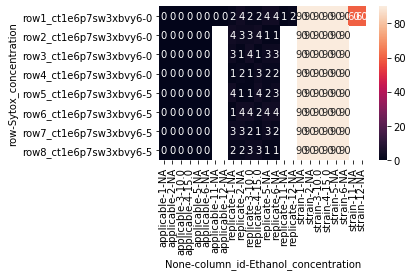

In [16]:
a = df.loc[df.batch ==0].drop(columns=['measurement_type', "timepoint", 
                     "sample", "container", "recovery_media", 
                     "batch", "temperature", "experiment_id"]).drop_duplicates().sort_values(by=["column_id", "row"])
mymap = {'None':1, 'MediaControl':60, 'MG1655_WT':30, 'Bacillus subtilis 168 Marburg' : 90}
a= a.applymap(lambda s: mymap.get(s) if s in mymap else s)
b = a.pivot_table(index=['row', 'Sytox_concentration'], columns=['column_id', 'Ethanol_concentration'])
import matplotlib.pyplot as plt
import seaborn as sns
sns.heatmap(b, annot=True)
plt.tight_layout()
#a

In [57]:
import numpy as np
df1 = pd.DataFrame({'A': [0, None], 'B': [4, 4]})
df2 = pd.DataFrame({'A': [None], 'B': ["NA"], }, index=[0])
def preserve_na(s1, s2):
    for i, v in s2.items():
        if v == "NA" or pd.isnull(s1[i]):
            s1[i] = v
    return s1
    
df1.combine(df2, preserve_na, overwrite=False)    

,A,B
0,0.0,NA
1,NaN,4


In [61]:
from pysmt.shortcuts import Symbol, And, GE, LT, Plus, Equals, Int, Real, REAL

def decode_constraint(constraint_str):
    return eval(constraint_str)

constraint=\
"""
And(
 Equals(Symbol(\"temperature(ct1e55w9xuhhm58)\", REAL), Real(35.0)), 
 Symbol(\"Cuminic Acid @ 88.0 hours_concentration_is_na(col1_ct1e55w9xmqbtx8)\")
 )
"""

formula = decode_constraint(constraint)
formula

(('temperature(ct1e55w9xuhhm58)' = 35.0) & 'Cuminic Acid @ 88.0 hours_concentration_is_na(col1_ct1e55w9xmqbtx8)')

In [ ]:
# define auth headers
tx_api = Connection.from_file("~/.transcriptic")
email = tx_api.email
token = tx_api.token
json_api_root = "{}/api".format(tx_api.api_root)
tx_api.organization_id = 'transcriptic'
headers = {'X-User-Email': email, 'X-User-Token': token}
def complete_instructions(proj_id, run_id):
    run_url = "https://secure.transcriptic.com/sd2org/{}/runs/{}/complete_all_instructions".format(proj_id, run_id)
    return requests.post(run_url, headers=headers).json
complete_instructions("p1bqm3ehqzgum", "r1eagp7uadhkuz")